In [43]:
# This notebook loads Max's neural net 
# and eigendecomposes the graph laplacian

# import needed libraries
import numpy as np
import scipy.linalg as linalg
import matplotlib.pyplot as plt

## load weights and biases

In [44]:
# load max's weights and biases
from load_params import *

In [45]:
#now look at the sizes of each set of weights/biases
for weight in weights:
    print(weight.shape)

#params has elements weights_0, biases_0, weights_1, biases_1, weights_2, biases_2, weights_3, biases_3

(784, 128)
(128, 64)
(64, 28)
(28, 10)


## create adjacency matrix

the adjacency matrix will look like

        784 + 128 + 64 + 28 + 10
    784  0    W0    0    0    0
    +128 W0'   0    W1'  0    0
    +64  0    W1'   0    W2   0
    +28  0    0     W2'  0    W3
    +10  0    0     0    W3'  0

In [46]:
layer_sizes = np.array([784, 128, 64, 28, 10])
num_neurons = np.sum(layer_sizes) # = 1014

#construct the adjacency matrix
A = np.zeros(shape = (num_neurons, num_neurons))

# get the locations of each block
blocks = np.r_[0, np.cumsum(layer_sizes)]   # e.g. [0, 784, 912, 976, 1004, 1014]
print('the blocks are located at')
print(blocks)

# initialize adjacency
A = np.zeros((num_neurons, num_neurons))

# just load the weight matrices into the blocks 
for i in range(4):
    #first just load the upper triangular part of the adjacency matrix

    #get the rows for each block
    first_row = blocks[i]
    last_row = blocks[i+1] 
    #and the columns for each block
    first_col = blocks[i+1]
    last_col = blocks[i+2] 

    # now assign the weight matrix to that block
    A[first_row : last_row , first_col : last_col] = weights[i]

    # mirror to make A symmetric
    A[first_col : last_col , first_row : last_row] = weights[i].T

the blocks are located at
[   0  784  912  976 1004 1014]


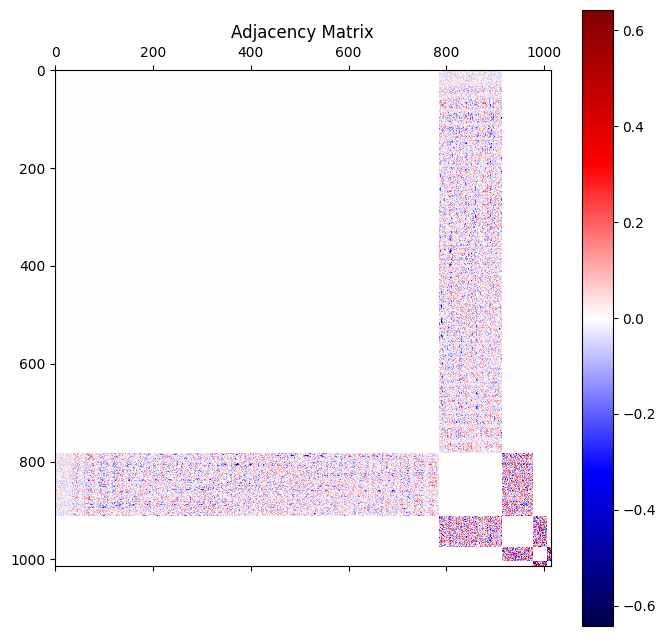

In [47]:
# plot heatmap of A

fig, ax = plt.subplots(figsize=(8, 8))  # Create a figure and an Axes
cax = ax.matshow(A, cmap='seismic', vmin = -np.max(abs(A)), vmax = np.max(abs(A)))  # Plot on the specified Axes
fig.colorbar(cax, ax=ax)  # Add colorbar to that Axes
plt.title("Adjacency Matrix")
plt.savefig("figures/adjacency.png")
plt.show()

## create graph laplacian

In [48]:
#create degree matrix
D = np.diag(A.sum(axis=1))

#calculate laplacian
L = D - A

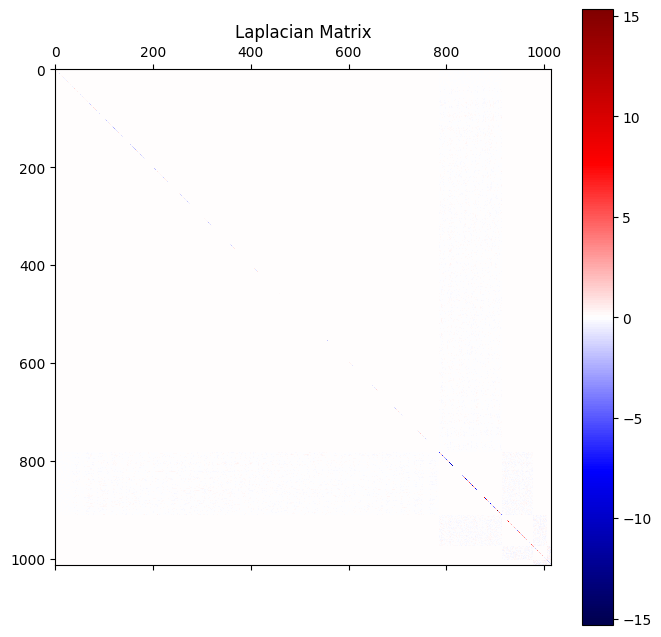

In [49]:

fig, ax = plt.subplots(figsize=(8, 8))  # Create a figure and an Axes
cax = ax.matshow(L, cmap='seismic', vmin = -np.max(abs(L)), vmax = np.max(abs(L)))  # Plot on the specified Axes
fig.colorbar(cax, ax=ax)  # Add colorbar to that Axes
plt.title("Laplacian Matrix")
plt.savefig("figures/laplacian.png")

## eigen-decompose

In [50]:
# Compute eigenvalues and eigenvectors of the Laplacian
eigenvalues, eigenvectors = linalg.eigh(L)

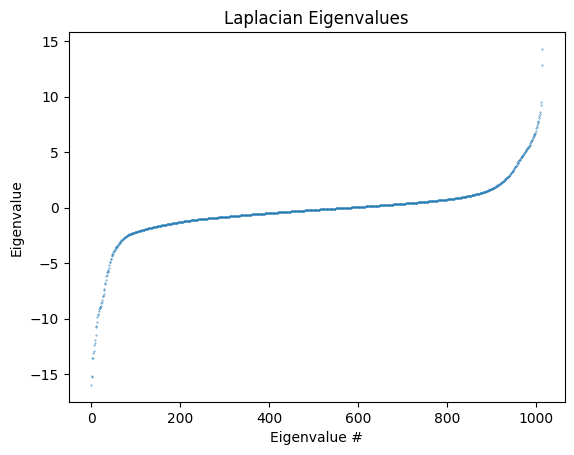

In [51]:
n = np.size(eigenvalues)
plt.xlabel("Eigenvalue #")
plt.ylabel("Eigenvalue")
plt.title("Laplacian Eigenvalues")
plt.scatter(np.arange(n), eigenvalues, s = 0.1)
#plt.hist(eigenvalues, bins = 100)
plt.savefig("figures/laplacian_eigenvals.png", dpi = 300)

In [57]:
# zero out some eigenvalues
zeroed_eigenvalues = eigenvalues.copy()
zeroed_eigenvalues[[]] = 0  # Zero out the fourth eigenvalue for example

In [58]:
# Reconstruct the Laplacian after modifying eigenvalues
L_reconstructed = eigenvectors @ np.diag(zeroed_eigenvalues) @ eigenvectors.T

## create new list of weights

In [59]:
weights_recons = []

for i in range(4):
    #get the rows for each block
    first_row = blocks[i]
    last_row = blocks[i+1] 
    #and the columns for each block
    first_col = blocks[i+1]
    last_col = blocks[i+2] 

    #get reconstructed weights from the reconstructed Laplacian
    W_recons = L_reconstructed[first_row : last_row , first_col : last_col] 
    weights_recons.append(W_recons)

In [61]:
#test that these are the same weights
diffs = []
for i in range(4):
    diffs.append(np.sum(weights[i] - weights_recons[i])**2)
print(diffs)

[228524.365635727, 26869.252402055954, 3337.4508715659244, 282.13411127723055]
